In [3]:
import warnings
from lambeq import QuantumTrainer, SPSAOptimizer
from helper import *
from lambeq import Dataset
import os
import numpy as np
import pandas as pd
import sklearn as sk
#import json

/home/jovyan/.qbraid/environments/womanium_go14xk/pyenv/lib/python3.9/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "true"
BATCH_SIZE = 50
EPOCHS = 120
RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)

In [5]:
df = pd.read_csv("MC1.txt", header=None, sep=", ", engine="python")

In [6]:
df.columns = ["s1", "s2", "label"]

df.head()

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1


In [7]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
df_train_val, df_test = train_test_split(df, test_size=0.2, shuffle=False)
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
rskf_splits = list(rskf.split(df_train_val[["s1", "s2"]], y=df_train_val["label"]))

In [8]:
ansatz = IQPAnsatz({AtomicType.NOUN: 2, AtomicType.SENTENCE: 1},
                       n_layers=1, n_single_qubit_params=3)

In [9]:
train_idx, val_idx = rskf_splits[0]
df_train, df_val = df_train_val.iloc[train_idx], df_train_val.iloc[val_idx]
df_train.shape

(64, 3)

In [10]:
print(df_train[df_train["label"] == 0].shape)
print(df_train[df_train["label"] == 1].shape)

(29, 3)
(35, 3)


In [11]:
preprocess_df_old(df_train, ansatz)
preprocess_df_old(df_val, ansatz)
preprocess_df_old(df_test, ansatz)
df.dropna()

Tagging sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/64 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/64 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/64 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/64 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/4 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/16 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/4 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/16 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/16 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/5 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/20 [00:00<?, ?it/s]

Tagging sentences:   0%|          | 0/5 [00:00<?, ?it/s]

Parsing tagged sentences:   0%|          | 0/20 [00:00<?, ?it/s]

Parse trees to diagrams:   0%|          | 0/20 [00:00<?, ?it/s]

,s1,s2,label
0,cook creates complicated dish,experienced chef prepares complicated dish,1
1,skilful programmer creates code,devoted hacker writes code,1
2,skilful cook creates meal,devoted hacker creates complicated code,0
3,hacker writes code,skilful hacker creates code,1
4,devoted hacker writes code,hacker writes complicated code,1
...,...,...,...
95,skilful programmer writes advanced code,skilful cook prepares meal,0
96,programmer creates code,chef creates dish,0
97,hacker creates code,chef prepares dish,0
98,skilful programmer creates complicated code,programmer writes complicated code,1


In [12]:
train_circuits = list(df_train[["s1_circuit", "s2_circuit"]].values)
val_circuits = list(df_val[["s1_circuit", "s2_circuit"]].values)
test_circuits = list(df_test[["s1_circuit", "s2_circuit"]].values)

In [13]:
all_circuits = train_circuits + val_circuits + test_circuits
assert len(all_circuits) == len(df)
train_diagrams = list(df_train[["s1_diagrams", "s2_diagrams"]].values)
val_diagrams = list(df_val[["s1_diagrams", "s2_diagrams"]].values)
test_diagrams = list(df_test[["s1_diagrams", "s2_diagrams"]].values)
all_diagrams = train_diagrams + val_diagrams + test_diagrams         
np.array(all_circuits).reshape(-1).shape

(200,)

In [14]:
train_labels = list(df_train["label_v"].values)
val_labels = list(df_val["label_v"].values)
test_labels = list(df_test["label_v"].values)
assert len(train_labels) > 0
assert(test_labels)
assert(val_labels)

In [15]:
model = ClassificationModel.from_diagrams(np.array(all_circuits).reshape(-1), use_jit=True)

In [16]:
epsilon=np.finfo('float').eps
loss = lambda y_hat, y: (-np.nansum(y * np.log(y_hat + epsilon)) + epsilon ) / len(y)
acc = lambda y_hat, y: np.nansum(np.round(y_hat) == y) / len(y)/ 2 if (len(y) > 0) else None
eval_metrics = {"acc": acc}

In [17]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={"a": 0.05, "c": 0.06, "A": 0.01 * EPOCHS},
    evaluate_functions=eval_metrics,
    verbose="text",
    seed=RANDOM_SEED,
)

In [18]:

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)
if not train_labels:
    raise Exception("Empty train labels list!")
if not val_labels:
    raise Exception("Empty test labels list!")
print(val_labels)

[[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1]]


In [19]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

Epoch 1:    train/loss: 1.6587   valid/loss: 1.1367   train/acc: 0.5000   valid/acc: 0.5625
Epoch 12:   train/loss: 1.3258   valid/loss: 0.8315   train/acc: 0.6250   valid/acc: 0.5625
Epoch 24:   train/loss: 0.7983   valid/loss: 0.7257   train/acc: 0.6250   valid/acc: 0.6250
Epoch 36:   train/loss: 0.5867   valid/loss: 0.5284   train/acc: 0.7188   valid/acc: 0.6875
Epoch 48:   train/loss: 0.5839   valid/loss: 0.7469   train/acc: 0.7500   valid/acc: 0.6250
Epoch 60:   train/loss: 0.6083   valid/loss: 0.6766   train/acc: 0.8438   valid/acc: 0.7500
Epoch 72:   train/loss: 0.4956   valid/loss: 0.5746   train/acc: 0.7812   valid/acc: 0.7500
Epoch 84:   train/loss: 0.4717   valid/loss: 0.4530   train/acc: 0.8281   valid/acc: 0.6875
Epoch 96:   train/loss: 0.4859   valid/loss: 0.4110   train/acc: 0.7812   valid/acc: 0.6875
Epoch 108:  train/loss: 0.5397   valid/loss: 0.3866   train/acc: 0.8438   valid/acc: 0.7500
Epoch 120:  train/loss: 0.4694   valid/loss: 0.4731   train/acc: 0.8594   valid/

In [19]:
np.save('accuracy_vals_train_IQPAnsatz5.npy', trainer.train_results['acc'])
np.save('accuracy_vals_val_IQPAnsatz5.npy', trainer.val_results['acc'])
np.save('cost_vals_train_IQPAnsatz5.npy', trainer.train_epoch_costs)
np.save('cost_vals_val_IQPAnsatz5.npy', trainer.val_costs)

(120,)


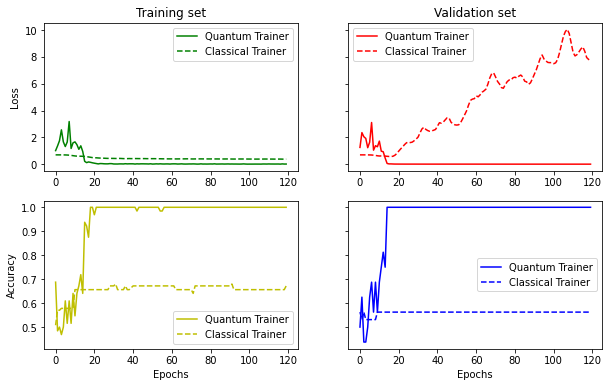

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Validation set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

IQPAnsatz_train_acc = np.load('accuracy_vals_train_IQPAnsatz4.npy')
IQPAnsatz_val_acc = np.load('accuracy_vals_val_IQPAnsatz4.npy')
IQPAnsatz_train_loss = np.load('cost_vals_train_IQPAnsatz4.npy')
IQPAnsatz_val_loss = np.load('cost_vals_val_IQPAnsatz4.npy')

print(np.shape(IQPAnsatz_train_acc))
tensor_train_acc = np.load('accuracy_vals_train_tensor_rewrite.npy')
tensor_val_acc = np.load('accuracy_vals_val_tensor_rewrite.npy')
tensor_train_loss = np.load('cost_vals_train_tensor_rewrite.npy')
tensor_val_loss = np.load('cost_vals_val_tensor_rewrite.npy')


ax_tl.plot(IQPAnsatz_train_loss, linestyle='-', color='g')
ax_tl.plot(tensor_train_loss, linestyle='--', color='g')
ax_tl.legend(['Quantum Trainer', 'Classical Trainer'])

ax_bl.plot(IQPAnsatz_train_acc, linestyle='-', color='y')
ax_bl.plot(tensor_train_acc, linestyle='--', color='y')
ax_bl.legend(['Quantum Trainer', 'Classical Trainer'])

ax_tr.plot(IQPAnsatz_val_loss, linestyle='-', color='r')
ax_tr.plot(tensor_val_loss, linestyle='--', color='r')
ax_tr.legend(['Quantum Trainer', 'Classical Trainer'])
ax_br.plot(IQPAnsatz_val_acc, linestyle='-', color='b')
ax_br.plot(tensor_val_acc, linestyle='--', color='b')
ax_br.legend(['Quantum Trainer', 'Classical Trainer'])



# print test accuracy


In [ ]:

from abc import ABC, abstractmethod
from collections.abc import Callable, Mapping
from datetime import datetime
from math import ceil
import os
import random
import socket
import sys
from typing import Any, Optional, Union
from typing import TYPE_CHECKING

from discopy import Tensor
from tqdm.notebook import tqdm, trange

if TYPE_CHECKING:
    from torch.utils.tensorboard import SummaryWriter

from lambeq.core.globals import VerbosityLevel
from lambeq.training.checkpoint import Checkpoint
from lambeq.training.dataset import Dataset
from lambeq.training.model import Model


def _import_tensorboard_writer() -> None:
    global SummaryWriter
    try:
        from torch.utils.tensorboard import SummaryWriter
    except ImportError:  # pragma: no cover
        raise ImportError('tensorboard not found. Please install it using '
                          '`pip install tensorboard`.')


_StrPathT = Union[str, 'os.PathLike[str]']


class CustomQuantumTrainer(QuantumTrainer):


    def validation_step(
            self,
            batch: tuple[list[Any], np.ndarray]) -> tuple[np.ndarray, float]:
        """Perform a validation step.
        Parameters
        ----------
        batch : tuple of list and np.ndarray
            Current batch.
        Returns
        -------
        tuple of np.ndarray and float
            The model predictions and the calculated loss.
        """
        x, y = batch
        y_hat = self.model(x)
        assert len(y) > 0
        #assert y_hat != 0
        print('Size of y from validation function', len(y))
        print('log(y_hat) from validation function', np.log(y_hat))
        loss = self.loss_function(y_hat, y)
        numerator_loss = -np.sum(y * np.log(y_hat + epsilon)) + epsilon
        denom_loss = len(y)
        print('calculated numerator loss from validation function', numerator_loss)
        print('calculated denom loss from validation function', denom_loss)
        print('calculated loss from validation function', loss)
        return y_hat, loss
    def fit(self,
            train_dataset: Dataset,
            val_dataset: Optional[Dataset] = None,
            evaluation_step: int = 1,
            logging_step: int = 1) -> None:
        """Fit the model on the training data and, optionally,
        evaluate it on the validation data.

        Parameters
        ----------
        train_dataset : :py:class:`Dataset`
            Dataset used for training.
        val_dataset : :py:class:`Dataset`, optional
            Validation dataset.
        evaluation_step : int, default: 1
            Sets the intervals at which the metrics are evaluated on the
            validation dataset.
        logging_step : int, default: 1
            Sets the intervals at which the training statistics are
            printed if `verbose = 'text'` (otherwise ignored).

        """
        if self.from_checkpoint:
            self._load_extra_chkpoint_info(self.checkpoint)

        def writer_helper(*args: Any) -> None:
            if self.use_tensorboard:
                self.writer.add_scalar(*args)
            else:
                print(*args)

        # initialise progress bar
        step = self.start_step
        batches_per_epoch = ceil(len(train_dataset)/train_dataset.batch_size)
        status_bar = tqdm(total=float('inf'),
                          bar_format='{desc}',
                          desc=self._generate_stat_report(),
                          disable=(
                                self.verbose != VerbosityLevel.PROGRESS.value),
                          leave=True,
                          position=0)

        # start training loop
        for epoch in trange(self.start_epoch,
                            self.epochs,
                            desc='Epoch',
                            disable=(
                                self.verbose != VerbosityLevel.PROGRESS.value),
                            leave=False,
                            position=1):
            train_loss = 0.0
            with Tensor.backend(self.backend):
                for batch in tqdm(train_dataset,
                                  desc='Batch',
                                  total=batches_per_epoch,
                                  disable=(self.verbose
                                           != VerbosityLevel.PROGRESS.value),
                                  leave=False,
                                  position=2):
                    step += 1
                    x, y_label = batch
                    y_hat, loss = self.training_step(batch)
                    writer_helper('y_hat', y_hat)
                    #if np.isnan(np.array(y_hat)).any():
                     #   raise Exception("Empty evaluation values list after training step!")
                    #if np.isnan(np.array(loss)).any():
                     #   raise Exception("Nan loss values list after training step!")
                    writer_helper('y_hat', y_hat)
                    if np.isnan(np.array(y_hat)).any():
                        raise Exception("Empty evaluation values list!")
                    if (self.evaluate_on_train
                            and self.evaluate_functions is not None):
                        for metr, func in self.evaluate_functions.items():
                            res = func(y_hat, y_label)
                            metric = self._train_results_epoch[metr]
                            metric.append(len(x) * res)
                    train_loss += len(batch[0]) * loss
                    assert np.isnan(np.array(loss)).any() == False
                    writer_helper('train/step_loss', loss, step)
                    status_bar.set_description(
                            self._generate_stat_report(
                                train_loss=loss,
                                val_loss=(self.val_costs[-1] if self.val_costs
                                          else None)))
            train_loss /= len(train_dataset)
            assert len(train_dataset) > 0
            print('y_label', y_label)
            if np.isnan(np.array(y_label)).any():
                raise Exception("Empty train label list!")
            if np.isnan(np.array(y_hat)).any():
                raise Exception("Empty evaluation values list!")
            self.train_epoch_costs.append(train_loss)
            writer_helper('train/epoch_loss', train_loss, epoch + 1)

            # evaluate on train
            if (self.evaluate_on_train
                    and self.evaluate_functions is not None):
                for name in self._train_results_epoch:
                    self.train_results[name].append(
                        sum(self._train_results_epoch[name])/len(train_dataset)
                    )
                    self._train_results_epoch[name] = []  # reset
                    writer_helper(
                        f'train/{name}', self.train_results[name][-1],
                        epoch+1)
                    if self.verbose == VerbosityLevel.PROGRESS.value:
                        status_bar.set_description(
                                self._generate_stat_report(
                                    train_loss=train_loss,
                                    val_loss=(self.val_costs[-1]
                                              if self.val_costs else None)))

            # evaluate metrics on validation data
            if val_dataset is not None:
                if epoch % evaluation_step == 0:
                    val_loss = 0.0
                    batches_per_validation = ceil(len(val_dataset)
                                                  / val_dataset.batch_size)
                    writer_helper('batches_per_validation', batches_per_validation, len(val_dataset), val_dataset.batch_size)
                    with Tensor.backend(self.backend):
                        disable_tqdm = (self.verbose
                                        != VerbosityLevel.PROGRESS.value)
                        for v_batch in tqdm(val_dataset,
                                            desc='Validation batch',
                                            total=batches_per_validation,
                                            disable=disable_tqdm,
                                            leave=False,
                                            position=2):
                            writer_helper("***", v_batch)
                            x_val, y_label_val = v_batch
                            writer_helper("***", x_val, y_label_val)
                            y_hat_val, cur_loss = self.validation_step(v_batch)
                            if np.isnan(np.array(y_hat)).any():
                                raise Exception("Empty evaluation values list after validation step!")
                            writer_helper("***", y_hat_val, cur_loss)
                            val_loss += cur_loss * len(x_val)
                            if self.evaluate_functions is not None:
                                for metr, func in (
                                        self.evaluate_functions.items()):
                                    res = func(y_hat_val, y_label_val)
                                    self._val_results_epoch[metr].append(
                                        len(x_val)*res)
                            status_bar.set_description(
                                    self._generate_stat_report(
                                        train_loss=train_loss,
                                        val_loss=val_loss))
                        assert len(val_dataset) > 0
                        writer_helper('empty val dataset!', len(val_dataset))
                        val_loss /= len(val_dataset)
                        self.val_costs.append(val_loss)
                        writer_helper('cost vals', self.val_costs)
                        status_bar.set_description(
                                self._generate_stat_report(
                                    train_loss=train_loss,
                                    val_loss=val_loss))
                        if np.isnan(np.array(val_loss)).any():
                            raise Exception("loss value is NaN!")
                        writer_helper('empty val dataset!', len(val_dataset))
                        writer_helper('val/loss', val_loss, epoch+1)

                    if self.evaluate_functions is not None:
                        for name in self._val_results_epoch:
                            assert len(val_dataset) > 0
                            writer_helper('empty val dataset!', len(val_dataset))
                            self.val_results[name].append(
                                sum(self._val_results_epoch[name])
                                / len(val_dataset))
                            self._val_results_epoch[name] = []  # reset
                            writer_helper(
                                f'val/{name}', self.val_results[name][-1],
                                epoch + 1)
                            status_bar.set_description(
                                    self._generate_stat_report(
                                        train_loss=train_loss,
                                        val_loss=val_loss))
            # save checkpoint info
            save_dict = {'epoch': epoch+1,
                         'model_weights': self.model.weights,
                         'model_symbols': self.model.symbols,
                        'train_costs': self.train_costs,
                         'train_epoch_costs': self.train_epoch_costs,
                         'train_results': self.train_results,
                         'val_costs': self.val_costs,
                         'val_results': self.val_results,
                         'random_state': random.getstate(),
                         'step': step}
            print(f"save_dict: {save_dict}")
            self.save_checkpoint(save_dict, self.log_dir)
            if self.verbose == VerbosityLevel.TEXT.value:
                if epoch == 0 or (epoch+1) % logging_step == 0:
                    space = (len(str(self.epochs))-len(str(epoch+1)) + 2) * ' '
                    prefix = f'Epoch {epoch+1}:' + space
                    print(prefix + self._generate_stat_report(
                            train_loss=train_loss,
                            val_loss=(self.val_costs[-1] if self.val_costs
                                      else None)),
                          file=sys.stderr)
        status_bar.close()
        if self.verbose == VerbosityLevel.TEXT.value:
            print('\nTraining completed!', file=sys.stderr)

In [ ]:
trainer2 = CustomQuantumTrainer(
    model,
    epochs=EPOCHS,
    loss_function=loss,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [ ]:
trainer2.fit(train_dataset, val_dataset, logging_step=12)

In [ ]:
from discopy.quantum import Circuit

In [ ]:
np.array(all_circuits).reshape(-1)
all_circuits[0]

In [ ]:
from pytket.circuit.display import render_circuit_jupyter
render_circuit_jupyter(all_circuits[0][0].to_tk())

In [ ]:
lambdified_diagram = model._get_lambda(train_circuits[0][0])
print(len(val_circuits))

In [ ]:
print(lambdified_diagram)

In [ ]:
print(len(model.weights))


In [ ]:
tensors = Circuit.eval(
    *lambdified_diagram(*model.weights),
    **model.backend_config,
    seed=model._randint(),
)

In [ ]:
lambdified_diagram(*model.weights)

In [ ]:
import numpy as np
epsilon=np.finfo('float64').eps
eps = 1e-50
np.log(eps + epsilon)/16

In [ ]:
import numpy as np
np.log(0)